In [1]:
from datasets import Dataset
import evaluate
import pandas as pd
import os
import glob

from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    DataCollatorWithPadding,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

def load_corpus(root_dir: str, min_length: int = 800, max_length: int = 2000):
    records = []
    for author_folder in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, author_folder)
        if not os.path.isdir(folder_path):
            continue
        for txt_file in glob.glob(os.path.join(folder_path, "*.txt")):
            with open(txt_file, "r", encoding="utf-8") as f:
                raw = f.read().strip().replace("\r\n", "\n")
            if len(raw) < min_length:
                continue
            start = 0
            while start < len(raw):
                end = start + max_length
                fragment = raw[start:end].strip()
                if len(fragment) >= min_length:
                    records.append({
                        "text": fragment,
                        "label": author_folder
                    })
                start += (max_length - min_length // 2)
    df = pd.DataFrame(records)
    return df

data_root = "./data"
df = load_corpus(data_root, min_length=800, max_length=2000)

print(df["label"].value_counts())

label
Достоевский    162
Пушкин         141
Булгаков       140
Толстой        137
Гоголь         136
Островский     120
Чехов          117
Тургенев       113
Лермонтов       39
Name: count, dtype: int64


In [2]:
import re

In [3]:
def regular_cleaning(text):
    text = re.sub(r"^Глава\s+\d+.*$", "", text, flags=re.MULTILINE)
    text = re.sub(r"\[.*?\]", "", text)  # убираем сноски
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"""[^a-zA-Zа-яА-Я0-9\s@=+%&'"!#?,.:;\/-]""", "", text, flags=re.IGNORECASE).lower()
    # text = re.sub(r"""[#\n]""", " ", text).lower()
    # text = re.sub(r'\s+', ' ', text).strip()
    return text
df["text"] = df["text"].apply(regular_cleaning)

In [4]:
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df["label"], shuffle=True
)

print("Train:", train_df.shape, "Test:", test_df.shape)

Train: (884, 2) Test: (221, 2)


In [5]:
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from transformers import get_linear_schedule_with_warmup
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy


model_name = 'DeepPavlov/rubert-base-cased'
# model_name = "ai-forever/ruBert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using", device)

Using cuda


In [7]:
model_BERT = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=9,
    problem_type="multi_label_classification"
).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
unique_labels = sorted(train_df["label"].unique().tolist())
num_labels = len(unique_labels)

label2id = {lab: idx for idx, lab in enumerate(unique_labels)}
id2label = {idx: lab for lab, idx in label2id.items()}

In [9]:
class AuthorsDataset(Dataset):
    def __init__(self, df, tokenizer, label2id, max_length=512):
        """
        df: pandas.DataFrame с колонками "text" и "label"
        tokenizer: AutoTokenizer
        label2id: dict {строка_фамилии: int_идекс}
        max_length: максимальная длина токенов
        """
        self.texts = df["text"].tolist()
        self.labels = df["label"].tolist()
        self.tokenizer = tokenizer
        self.label2id = label2id
        self.max_length = max_length
        self.num_labels = len(label2id)
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        lab = self.labels[idx]
        encoding = self.tokenizer(
            text, 
            add_special_tokens=True,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_attention_mask=True,
            return_tensors="pt"
        )
        label_vector = np.zeros(self.num_labels, dtype=float)
        label_index = self.label2id[lab]
        label_vector[label_index] = 1.0
        
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label_vector, dtype=torch.float)
        }
train_dataset = AuthorsDataset(train_df, tokenizer, label2id, max_length=512)
val_dataset   = AuthorsDataset(test_df,   tokenizer, label2id, max_length=512)

batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


Epoch 1/5


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.95it/s]


Train Loss: 0.5316 | Val Loss: 0.3735
Train F1: 0.0621 | Val F1: 0.0000
Learning Rate: 1.78e-05

Epoch 2/5


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.87it/s]


Train Loss: 0.3517 | Val Loss: 0.3286
Train F1: 0.0000 | Val F1: 0.0000
Learning Rate: 1.33e-05

Epoch 3/5


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.86it/s]


New best model saved with F1: 0.1041
Train Loss: 0.3207 | Val Loss: 0.3026
Train F1: 0.0475 | Val F1: 0.1041
Learning Rate: 8.89e-06

Epoch 4/5


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.87it/s]


New best model saved with F1: 0.1403
Train Loss: 0.2956 | Val Loss: 0.2808
Train F1: 0.0905 | Val F1: 0.1403
Learning Rate: 4.44e-06

Epoch 5/5


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.92it/s]


New best model saved with F1: 0.1493
Train Loss: 0.2771 | Val Loss: 0.2696
Train F1: 0.1414 | Val F1: 0.1493
Learning Rate: 0.00e+00


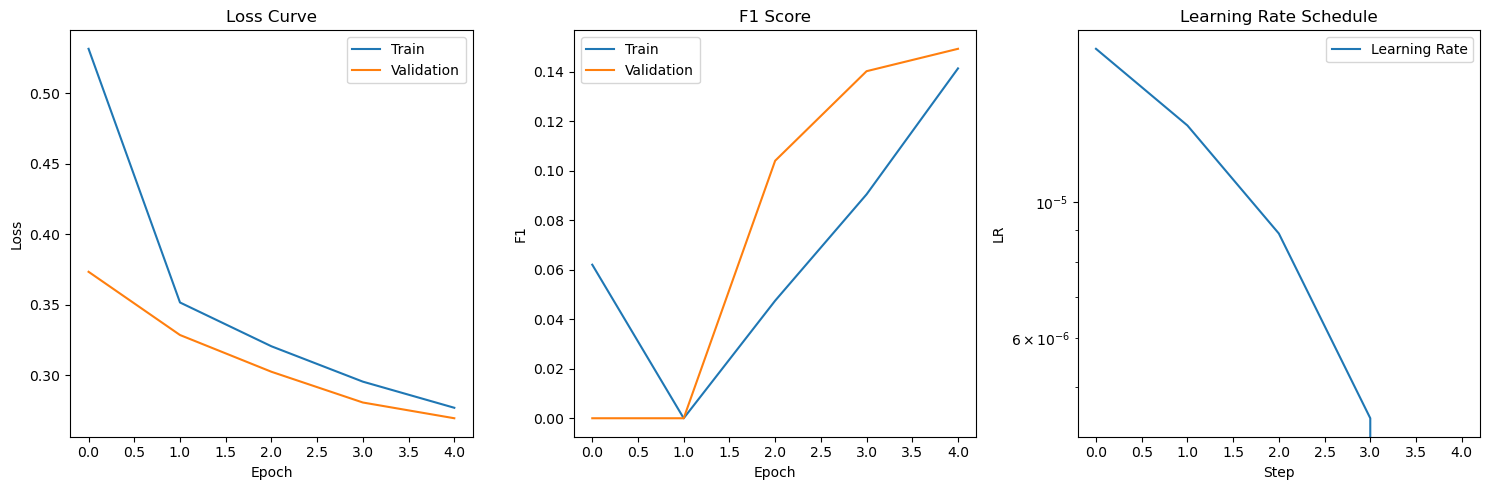

In [10]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, metric='f1'):
        self.patience = patience
        self.delta = delta
        self.metric = metric
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, current_score):
        if self.best_score is None:
            self.best_score = current_score
        elif current_score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = current_score
            self.counter = 0

def calculate_metrics(outputs, labels, threshold=0.5):
    probs = torch.sigmoid(outputs)
    preds = (probs > threshold).float()
    
    # Sample-based F1 score
    f1 = f1_score(labels.cpu().numpy(), 
                 preds.cpu().numpy(), 
                 average='samples', 
                 zero_division=0)
    return f1

def train_epoch(model, dataloader, optimizer, scheduler_warmup=None):
    model.train()
    total_loss = 0.0
    total_f1 = 0.0
    
    for batch in tqdm(dataloader, desc="Training"):
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        if scheduler_warmup:
            scheduler_warmup.step()
        
        total_loss += loss.item()
        f1 = calculate_metrics(outputs.logits, labels)
        total_f1 += f1 * input_ids.size(0)
    
    return {
        'loss': total_loss / len(dataloader),
        'f1': total_f1 / len(dataloader.dataset)
    }

def validate_epoch(model, dataloader):
    model.eval()
    total_loss = 0.0
    total_f1 = 0.0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            total_loss += loss.item()
            f1 = calculate_metrics(outputs.logits, labels)
            total_f1 += f1 * input_ids.size(0)
    
    return {
        'loss': total_loss / len(dataloader),
        'f1': total_f1 / len(dataloader.dataset)
    }

optimizer = torch.optim.AdamW(model_BERT.parameters(), lr=2e-5, weight_decay=0.01)
total_steps = len(train_loader) * 5
scheduler_warmup = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=total_steps//10,
    num_training_steps=total_steps
)
scheduler_plateau = ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5)

early_stopping = EarlyStopping(patience=5, delta=0.001, metric='f1')

history = {
    'train_loss': [],
    'val_loss': [],
    'train_f1': [],
    'val_f1': [],
    'lr': []
}

best_f1 = 0.0
best_model = None

for epoch in range(5):
    print(f"\nEpoch {epoch + 1}/5")
    
    train_metrics = train_epoch(model_BERT, train_loader, optimizer, scheduler_warmup)
    
    val_metrics = validate_epoch(model_BERT, val_loader)
    
    history['train_loss'].append(train_metrics['loss'])
    history['val_loss'].append(val_metrics['loss'])
    history['train_f1'].append(train_metrics['f1'])
    history['val_f1'].append(val_metrics['f1'])
    history['lr'].append(optimizer.param_groups[0]['lr'])
    
    scheduler_plateau.step(val_metrics['f1'])
    
    if val_metrics['f1'] > best_f1:
        best_f1 = val_metrics['f1']
        best_model = copy.deepcopy(model_BERT.state_dict())
        torch.save(best_model, 'best_bert_model.pth')
        print(f"New best model saved with F1: {best_f1:.4f}")
    
    early_stopping(val_metrics['f1'])
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break
    
    print(f"Train Loss: {train_metrics['loss']:.4f} | Val Loss: {val_metrics['loss']:.4f}")
    print(f"Train F1: {train_metrics['f1']:.4f} | Val F1: {val_metrics['f1']:.4f}")
    print(f"Learning Rate: {history['lr'][-1]:.2e}")

model_BERT.load_state_dict(torch.load('best_bert_model.pth'))
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(132)
plt.plot(history['train_f1'], label='Train')
plt.plot(history['val_f1'], label='Validation')
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.legend()

plt.subplot(133)
plt.plot(history['lr'], label='Learning Rate')
plt.title('Learning Rate Schedule')
plt.xlabel('Step')
plt.ylabel('LR')
plt.yscale('log')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
model_BERT.eval()
example_text = """Пихарь"""
encoding = tokenizer(
    example_text,
    padding="max_length",
    truncation=True,
    max_length=512,
    return_tensors="pt"
).to(device)

with torch.no_grad():
    outputs = model_BERT(
        input_ids=encoding["input_ids"],
        attention_mask=encoding["attention_mask"]
    )
    logits = outputs.logits
    probs = torch.sigmoid(logits).cpu().numpy()[0]

threshold = 0.1
pred_indices = np.where(probs > threshold)[0].tolist()
predicted_labels = [id2label[idx] for idx in pred_indices]
# print("Предсказанные фамилии (prob > 0.5):", predicted_labels)
print("Вероятности:", {id2label[i]: float(probs[i]) for i in pred_indices})

Вероятности: {'Булгаков': 0.24182091653347015, 'Гоголь': 0.26145607233047485, 'Достоевский': 0.25731661915779114, 'Лермонтов': 0.1917535960674286, 'Островский': 0.29839059710502625, 'Пушкин': 0.22072932124137878, 'Толстой': 0.23105573654174805, 'Тургенев': 0.2572425603866577, 'Чехов': 0.2323167324066162}
